# Switch Selection Procedures for Network Traffic Estimation
In this notebook, we define three switch selection procedures to be used in Kalman filtering for network traffic estimation in SDN: round-robin, uniform-random and top-variance. We apply these procedures to a network trace generated in a mininet environment and we compare them in terms of accuracy of the packet rate estimates.

## Network Environment
We created a random network and generated flows between the hosts by using iPerf3 in mininet. We used a Ryu controller to track and record the packet counts in the switches.

### Controller
We implement a controller based on the built-in Simple Switch STP application in Ryu. Our controller basically performs two tasks: filling the flow tables to implement the shortest path routing mechanism and collecting and recording the flow statistics from the switches periodically. The rules inserted by the controller match the input port of of the received packet and its destination mac address then forward it to the corresponding output port.

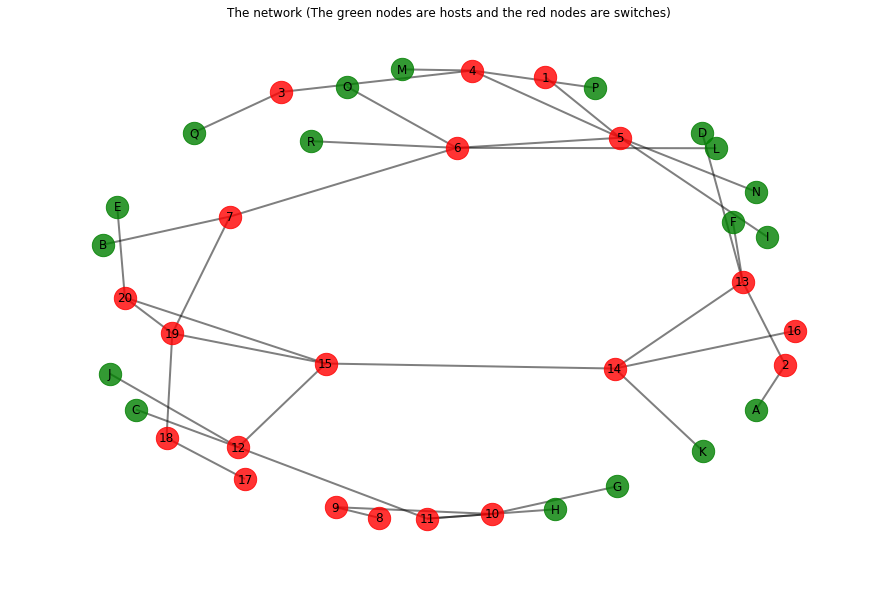

=== The Network Properties ===
The number of switches: 20
The number of hosts: 18
The number of links: 38


In [1]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_uppercase

# The figure size
plt.rcParams['figure.figsize'] = (15, 10)  

# Load the trace data
with open('trace_2017-09-17_18-47-41.pkl','rb') as trace_file:
    trace_dict = pickle.load(trace_file, encoding='latin1')

# Construct the network
G = nx.Graph()
G.add_edges_from(trace_dict['switch_links'])
switches = G.nodes()
hosts = list(set([link[0] for link in trace_dict['host_links']]))
hname = {mac:c for mac,c in zip(hosts,ascii_uppercase)}
host_names = [hname[mac] for mac in hosts]
G.add_edges_from([(hname[link[0]],link[1]) for link in trace_dict['host_links']])

# Plot the network
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=switches,node_color='r', node_size=500, alpha=0.8,with_labels=True)
nx.draw_networkx_nodes(G, pos, nodelist=host_names,node_color='g', node_size=500, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=2.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, width=2.0, alpha=0.9)
plt.title('The network (The green nodes are hosts and the red nodes are switches)')
plt.axis('off')
plt.show()  

# Print the network properties
print('=== The Network Properties ===')
print('The number of switches:',len(switches))
print('The number of hosts:',len(hosts))
print('The number of links:',len(G.edges()))
print('==============================')

## Inference on Network Traffic
The traffic in a network can be described by the flows between hosts. We refer these flows as Origin-Destination (OD) pairs. We construct a flow vector $\mathbf{x}$ (conceptually a matrix) that captures the amount of packets transmitted per second between every OD pair. If there are $n$ hosts in the network, then the length of the $\mathbf{x}$ is $c=n(n-1)$. The packet counts in the flow tables can be calculated by $\mathbf{y}=\mathbf{Ax}$.
Here $y^i$ denotes the number of packets matched by rule $i$ and $\mathbf{A}$ denotes the $r \times c$ routing matrix where $r$ it the number of rules. Element $A^{i,j}$ is $1$ if the rule $i$ matches OD pair $j$ or $0$ otherwise. The packet counts are measured periodically, therefore we denote the packet count vector as $\mathbf{y}_t$ and the flow vector as $\mathbf{x}_t$ at time $t, t=1,\ldots,T$. The linear relation in this case is the following,
$$
\mathbf{y}_t=\mathbf{A}\sum_{i=0}^{t}\mathbf{x}_i
$$
At each time step, some of the packet counts are measured with an error, $\mathbf{z}_t = \mathbf{M}_t\mathbf{y}_t + \mathbf{\epsilon}$, where $\mathbf{\epsilon}$ is multivariate zero-mean Gaussian noise with covariance $\sigma_\epsilon^2\mathbf{I}$ ($\mathbf{I}$ is the identity matrix).
$\mathbf{M}_t$ is a measurement matrix which selects some entries of $\mathbf{y}_t$ at time $t$.
The problem here is to estimate both $\mathbf{y}_t$ and $\mathbf{x}_t$ vectors by using partial noisy measurements $(\mathbf{z}_1,\ldots, \mathbf{z}_t)$ which we hereafter write as $\mathbf{z_{1:t}}$. More formally we want to obtain the joint posterior distribution $p(\mathbf{y}_t,\mathbf{x}_t{\mid}\mathbf{z_{1:t}},\mathbf{M_{1:t}})$

### Kalman Filter
We assume OD flows are self-similar, therefore we assume the difference between two consecutive flow vectors is normally distributed i.e. $\mathbf{x}_{t+1} \sim \mathcal{N}(\mathbf{x}_t,\sigma_\nu^2 \mathbf{I})$. In this case we can design the following linear Gaussian state space model,
$$
\mathbf{s}_0 \sim \mathcal{N}(\mathbf{0},\mathbf{\Sigma_0}), \ \ \  \\
\mathbf{s}_{t+1} = \mathbf{F}\mathbf{s}_t + \nu , \ \ \ \mathbf{\nu} \sim \mathcal{N}(\mathbf{0},\mathbf{Q}) \\
\mathbf{z}_t = \mathbf{H}_t\mathbf{s}_t + \mathbf{\epsilon}, \ \ \ \mathbf{\epsilon} \sim  \mathcal{N}(\mathbf{0},\mathbf{R})
$$
where
$$
\mathbf{s}_t = \begin{bmatrix}\mathbf{x}_t \\ \mathbf{y}_t\end{bmatrix}, \ \ \
\mathbf{F}_t = \begin{bmatrix}\mathbf{I} & \mathbf{0} \\ \mathbf{A} & \mathbf{I}\end{bmatrix}, \ \ \
\mathbf{H}_t = \begin{bmatrix}\mathbf{0} & \mathbf{M}_t \end{bmatrix} \\
\mathbf{\Sigma_0} = \begin{bmatrix} \sigma_w^2\mathbf{I} & \mathbf{0} \\ \mathbf{0} & \mathbf{0}\end{bmatrix}, \ \ \
\mathbf{Q} = \begin{bmatrix} \sigma_\nu^2\mathbf{I} & \mathbf{0} \\ \mathbf{0} & \mathbf{0}\end{bmatrix}, \ \ \
\mathbf{R} = \sigma_\epsilon^2 \mathbf{I} \ \ \
$$

The Kalman filter is the optimal estimator for this model. It provides the posterior distribution of the state vector $\mathbf{s}_t$ at time $t$ given all the measurements $\mathbf{z}_{1:t}$ until time $t$. The estimate of the state is a weighted average of the predicted state and the measured state. The weights are calculated using covariance matrix such that the values having smaller variance have larger weights. There are two main steps:

**Prediction Step:**

Predicted state estimate	$\hat{\mathbf {s} }_{t\mid t-1}=\mathbf {F}_{t}{\hat {\mathbf {s} }}_{t-1\mid t-1}$

Predicted estimate covariance	$\mathbf {P} _{t\mid t-1}=\mathbf {F}_{t}\mathbf {P}_{t-1\mid t-1}\mathbf {F}_{t}^{\mathrm {T} }+\mathbf {Q} _{t}$


**Update Step:**

Optimal Kalman gain	$\mathbf {K} _{t}=\mathbf {P} _{t\mid t-1}\mathbf {H} _{t}^{\mathrm {T} }
(\mathbf {R}_{t}+\mathbf {H} _{t}\mathbf {P} _{t\mid t-1}\mathbf {H} _{t}^{\mathrm {T} })^{-1}$

Updated  state estimate	$\hat {\mathbf {s} }_{t\mid t}={\hat {\mathbf {s} }}_{t\mid t-1}
\mathbf{K}_{t}(\mathbf {z} _{t}-\mathbf {H} _{t}{\hat {\mathbf {s} }}_{t\mid t-1})$

Updated estimate covariance	$\mathbf {P}_{t|t}=(\mathbf{I} -\mathbf{K}_{t}\mathbf{H}_{t})\mathbf {P} _{t|t-1}$

In [2]:
import numpy as np
import time
from kalman_filter import InferenceModule, sparse, I

trace = trace_dict['trace2']
T = trace_dict['T']
trace = trace[np.arange(0,T,10),:]/10  # 10 seconds intervals
trace = trace[4:,:]  # Cut off the initialization time
trace = trace - trace[0,:]  # Calibrate the packet counts
trace = trace[1:,:]
T, L = trace.shape


# Remove the inactive rules
A = trace_dict['B']
links = trace_dict['switch_to_rules']
empty_links = sorted([i for i in range(A.shape[0]) if np.sum(A[i,:]) == 0])
for s in links:
    new_links = []
    for i,l in enumerate(links[s]):
        j=np.searchsorted(empty_links,l)
        if j==len(empty_links) or empty_links[j] != l:
            new_links.append(l-j)
    links[s] = new_links
nonempty_links = sorted(list(set(range(A.shape[0]))-set(empty_links)))
A=A[nonempty_links,:]
trace = trace[:,nonempty_links]
L, H2 = A.shape

# Full measurement matrix
MM = sparse(np.bmat([np.zeros((L,H2)),  I(L)]))  # Full measurement

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


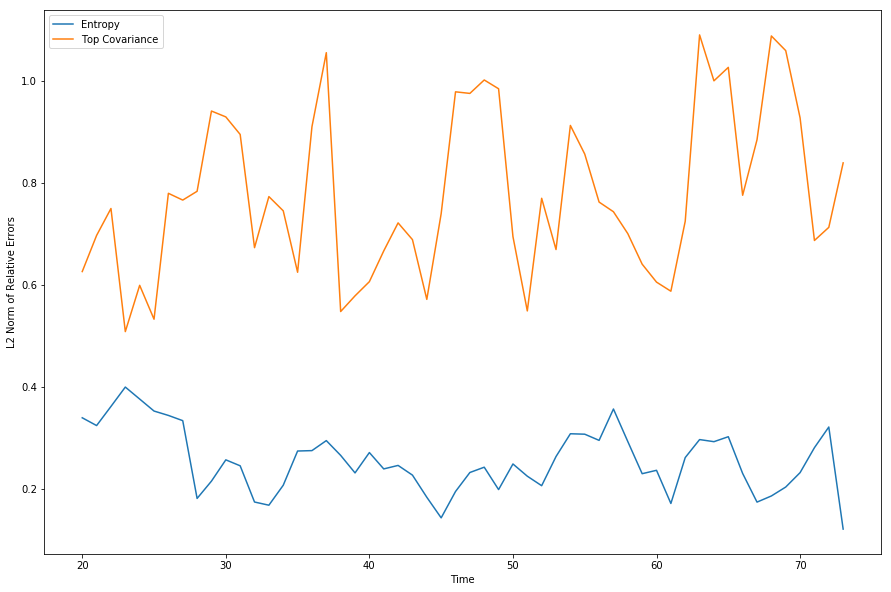

In [3]:
actual = trace[1:,:]-trace[:-1,:]
af = [flow_id for flow_id in range(L) if np.sum(trace.T[flow_id,:]) > 100*T*2]

# Run the Kalman filter for two procedures
n = 4
kf = InferenceModule(A,links)
kf_tc = InferenceModule(A,links,top_cov=True)
estimate = []
estimate_tc = []

for t in range(T):
    print(t,end=' ')
    s, M = kf.decide(n=n)
    kf.filter(M[:,H2:].dot(trace.T[:,t]),M)
    estimate.append(np.copy(kf.x[H2:]))
    
    s, M = kf_tc.decide(n=n)
    kf_tc.filter(M[:,H2:].dot(trace.T[:,t]),M)
    estimate_tc.append(np.copy(kf_tc.x[H2:]))
print('')
estimate = np.array(estimate)
estimate_tc = np.array(estimate_tc)

rate_estimate = estimate[1:,:]-estimate[:-1,:]
rate_estimate_tc = estimate_tc[1:,:]-estimate_tc[:-1,:]

t0 = 20
err = np.abs(rate_estimate[t0:,af]-actual[t0:,af])/actual[t0:,af]
err_tc = np.abs(rate_estimate_tc[t0:,af]-actual[t0:,af])/actual[t0:,af]

err_l2 = np.sqrt(np.sum(err**2,axis=1))
err_l2_tc = np.sqrt(np.sum(err_tc**2,axis=1))

plt.figure()
plt.plot(np.arange(len(err_l2[t0:]))+t0,err_l2[t0:],label='Entropy')
plt.plot(np.arange(len(err_l2_tc[t0:]))+t0,err_l2_tc[t0:],label='Top Covariance')
plt.xlabel('Time')
plt.ylabel('L2 Norm of Relative Errors')
plt.legend()
plt.show()



In [4]:
# Run the Kalman filter for two procedures
kf = InferenceModule(A,links)
kf_random = InferenceModule(A,links,random=True)
kf_rr = InferenceModule(A,links,round_robin=True)

all_estimates = {}

N = 10  # The maximum number of switches to be queried
K = 2**7  # The number of iterations required for random selection

for n in range(1,N+1):
    print('The number of switches selected:', n)
    estimate = []

    print('N:',n,', Min Entropy simulations have started!')
    for t in range(T):
        s, M = kf.decide(n=n)
        kf.filter(M[:,H2:].dot(trace.T[:,t]),M)
        estimate.append(np.copy(kf.x[H2:]))
    
    print('N:',n,', Min Entropy simulations have finished!')
    
#     estimate_random_list = []
#     estimate_rr_list = []
#     print('N:',n,', Random and Round Robin Simulations have started!')
#     print('N:',n,', Iteration:',end=' ')
#     for k in range(K):
#         print(k+1,end=' ')
#         estimate_random = []
#         estimate_rr = []
#         for t in range(T):
#             s, M = kf_random.decide(n=n)
#             kf_random.filter(M[:,H2:].dot(trace.T[:,t]),M)
#             estimate_random.append(np.copy(kf_random.x[H2:])) 
            
#             s, M = kf_rr.decide(n=n)
#             kf_rr.filter(M[:,H2:].dot(trace.T[:,t]),M)
#             estimate_rr.append(np.copy(kf_rr.x[H2:]))
            
#         estimate_random_list.append(np.array(estimate_random))
#         estimate_rr_list.append(np.array(estimate_rr))
#     print('\nN:',n,', Random and Round Robin Simulations have finished!')
    print('N:',n,', Adding to the results...')
    all_estimates[n] = {
        'estimate' : np.array(estimate),
#         'estimate_rr_list' : np.dstack(estimate_rr_list),
#         'estimate_random_list' : np.dstack(estimate_random_list)
    }
    
# Load the trace data
print('Saving..')
with open('all_estimates2.pkl','wb') as output:
    pickle.dump(all_estimates,output)
print('Done!')    

The number of switches selected: 1
N: 1 , Min Entropy simulations have started!
N: 1 , Min Entropy simulations have finished!
N: 1 , Adding to the results...
The number of switches selected: 2
N: 2 , Min Entropy simulations have started!
N: 2 , Min Entropy simulations have finished!
N: 2 , Adding to the results...
The number of switches selected: 3
N: 3 , Min Entropy simulations have started!
N: 3 , Min Entropy simulations have finished!
N: 3 , Adding to the results...
The number of switches selected: 4
N: 4 , Min Entropy simulations have started!
N: 4 , Min Entropy simulations have finished!
N: 4 , Adding to the results...
The number of switches selected: 5
N: 5 , Min Entropy simulations have started!
N: 5 , Min Entropy simulations have finished!
N: 5 , Adding to the results...
The number of switches selected: 6
N: 6 , Min Entropy simulations have started!
N: 6 , Min Entropy simulations have finished!
N: 6 , Adding to the results...
The number of switches selected: 7
N: 7 , Min Entrop

In [7]:
# Load the simulation results
with open('all_estimates.pkl','rb') as input:
    all_estimates = pickle.load(input) 
    
# Load the simulation results
with open('all_estimates2.pkl','rb') as input:
    all_estimates2 = pickle.load(input) 

for n in all_estimates:
    all_estimates[n]['estimate_tc'] = all_estimates[n]['estimate']
    all_estimates[n]['estimate'] = all_estimates2[n]['estimate']
with open('all_estimates.pkl','wb') as output:
    pickle.dump(all_estimates,output)

The number of active flows:  100


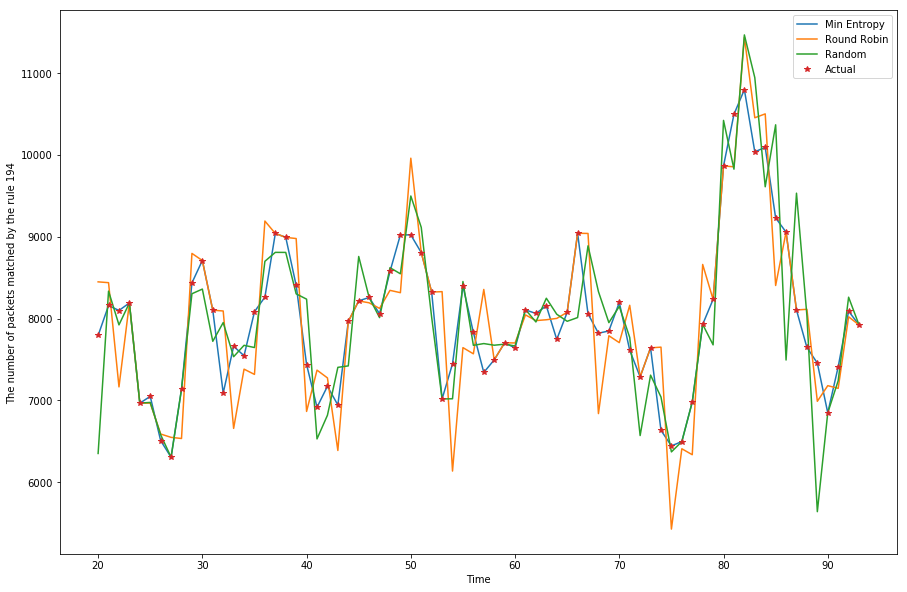

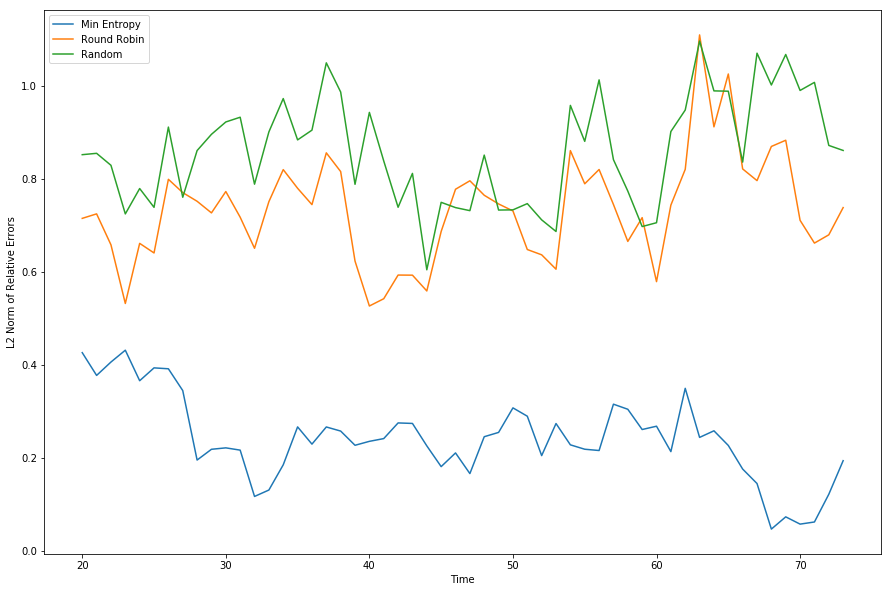

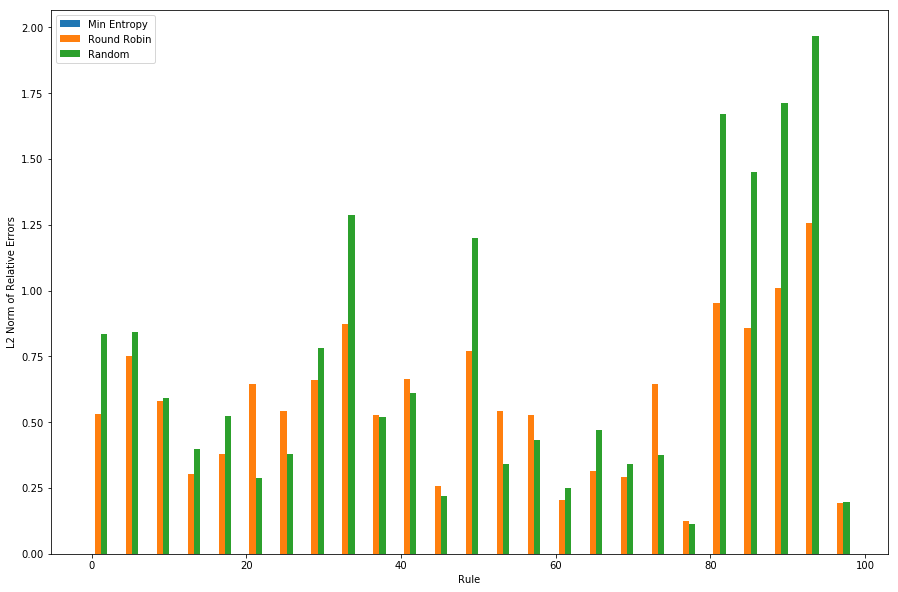

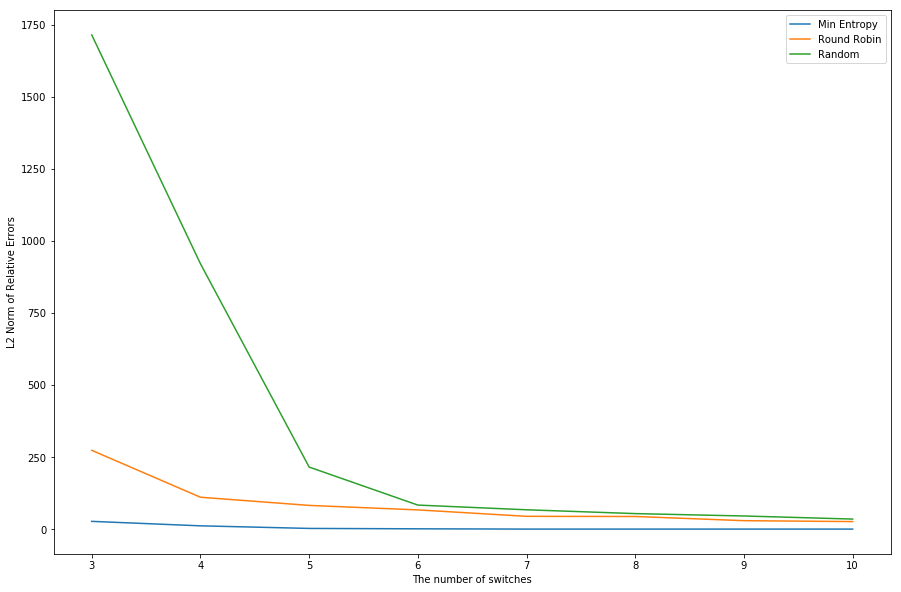

In [38]:
actual = trace[1:,:]-trace[:-1,:]

# Active flows
af = [flow_id for flow_id in range(L) if np.sum(trace.T[flow_id,:]) > 100*T*2]
print('The number of active flows: ',len(af))

# Load the simulation results
with open('all_estimates.pkl','rb') as input:
    all_estimates = pickle.load(input) 

n = 5
estimate = all_estimates[n]['estimate']
estimate_rr_list = all_estimates[n]['estimate_rr_list']
estimate_random_list = all_estimates[n]['estimate_random_list']

rate_estimate = estimate[1:,:]-estimate[:-1,:]
rate_estimate_rr_list = estimate_rr_list[1:,:,:]-estimate_rr_list[:-1,:,:]
rate_estimate_random_list = estimate_random_list[1:,:,:]-estimate_random_list[:-1,:,:]

t0 = 20
random_flows = np.random.choice(af,1,replace=False)
for flow_id in random_flows:
    plt.figure()
    plt.plot(np.arange(len(rate_estimate[t0:]))+t0,rate_estimate[t0:,flow_id],label='Min Entropy')
    plt.plot(np.arange(len(rate_estimate[t0:]))+t0,rate_estimate_rr_list[t0:,flow_id,0],label='Round Robin')
    plt.plot(np.arange(len(rate_estimate[t0:]))+t0,rate_estimate_random_list[t0:,flow_id,0],label='Random')
    plt.plot(np.arange(len(rate_estimate[t0:]))+t0,actual[t0:,flow_id],'*',label='Actual')
    plt.xlabel('Time')
    plt.ylabel('The number of packets matched by the rule '+str(flow_id))
    plt.legend()
    plt.show()

err = np.abs(rate_estimate[t0:,af]-actual[t0:,af])/actual[t0:,af]
err_rr_list = np.copy(rate_estimate_rr_list[t0:,af,:])
err_random_list = np.copy(rate_estimate_random_list[t0:,af,:])
for k in range(err_rr_list.shape[2]):
    err_rr_list[:,:,k] = np.abs(err_rr_list[:,:,k]-actual[t0:,af])/actual[t0:,af]
    err_random_list[:,:,k] = np.abs(err_random_list[:,:,k]-actual[t0:,af])/actual[t0:,af]    

# Total L2 error versus time
err_l2 = np.sqrt(np.sum(err**2,axis=1))
err_l2_rr = np.mean(np.sqrt(np.sum(err_rr_list**2,axis=1)),axis=1)
err_l2_random = np.mean(np.sqrt(np.sum(err_random_list**2,axis=1)),axis=1)
err_l2_rr_std = np.std(np.sqrt(np.sum(err_rr_list**2,axis=1)),axis=1)
err_l2_random_std = np.std(np.sqrt(np.sum(err_random_list**2,axis=1)),axis=1)

plt.figure()
plt.plot(np.arange(len(err_l2[t0:]))+t0,err_l2[t0:],label='Min Entropy')
plt.plot(np.arange(len(err_l2[t0:]))+t0,err_l2_rr[t0:],label='Round Robin')
plt.plot(np.arange(len(err_l2[t0:]))+t0,err_l2_random[t0:],label='Random')
# plt.plot(np.arange(len(err_l2))+t0,err_l2,label='Top Variance')
# plt.errorbar(np.arange(len(err_l2))+t0,err_l2_rr,yerr=err_l2_rr_std,label='Round Robin')
# plt.errorbar(np.arange(len(err_l2))+t0,err_l2_random,yerr=err_l2_random_std,label='Random')
plt.xlabel('Time')
plt.ylabel('L2 Norm of Relative Errors')
plt.legend()
plt.show()

# Total L2 error versus time
err_l2 = np.sqrt(np.sum(err**2,axis=0))
err_l2_rr = np.mean(np.sqrt(np.sum(err_rr_list**2,axis=0)),axis=1)
err_l2_random = np.mean(np.sqrt(np.sum(err_random_list**2,axis=0)),axis=1)
err_l2_rr_std = np.std(np.sqrt(np.sum(err_rr_list**2,axis=0)),axis=1)
err_l2_random_std = np.std(np.sqrt(np.sum(err_random_list**2,axis=0)),axis=1)

plt.figure()
ind = np.arange(0,len(err_l2),4)
plt.bar(ind,err_l2[ind],label='Min Entropy')
plt.bar(ind+0.8,err_l2_rr[ind],label='Round Robin')
plt.bar(ind+1.6,err_l2_random[ind],label='Random')
plt.xlabel('Rule')
plt.ylabel('L2 Norm of Relative Errors')
plt.legend()
plt.show()

err_l2_list = []
err_l2_rr_list = []
err_l2_random_list = []
n_list = sorted(all_estimates.keys())
for n in n_list[2:]:
    estimate = all_estimates[n]['estimate']
    estimate_rr_list = all_estimates[n]['estimate_rr_list']
    estimate_random_list = all_estimates[n]['estimate_random_list']

    rate_estimate = estimate[1:,:]-estimate[:-1,:]
    rate_estimate_rr_list = estimate_rr_list[1:,:,:]-estimate_rr_list[:-1,:,:]
    rate_estimate_random_list = estimate_random_list[1:,:,:]-estimate_random_list[:-1,:,:]
    
    err = np.abs(rate_estimate[t0:,af]-actual[t0:,af])/actual[t0:,af]
    err_rr_list = np.copy(rate_estimate_rr_list[t0:,af,:])
    err_random_list = np.copy(rate_estimate_random_list[t0:,af,:])
    for k in range(err_rr_list.shape[2]):
        err_rr_list[:,:,k] = np.abs(err_rr_list[:,:,k]-actual[t0:,af])/actual[t0:,af]
        err_random_list[:,:,k] = np.abs(err_random_list[:,:,k]-actual[t0:,af])/actual[t0:,af]    
    
    err_l2 = np.sqrt(np.sum(err**2))
    err_l2_rr = np.mean(np.sqrt(np.sum(np.sum(err_rr_list**2,axis=0))))
    err_l2_random = np.mean(np.sqrt(np.sum(np.sum(err_random_list**2,axis=0))))

    err_l2_list.append(err_l2)
    err_l2_rr_list.append(err_l2_rr)
    err_l2_random_list.append(err_l2_random)

plt.figure()
plt.plot(np.arange(len(n_list[2:]))+3,err_l2_list,label='Min Entropy')
plt.plot(np.arange(len(n_list[2:]))+3,err_l2_rr_list,label='Round Robin')
plt.plot(np.arange(len(n_list[2:]))+3,err_l2_random_list,label='Random')
plt.xlabel('The number of switches')
plt.ylabel('L2 Norm of Relative Errors')
plt.legend()
plt.show()

## Metropolis-Hasting for Parameter Inference

In [6]:
#Plot the histogram of selected switches
# plt.figure()
# plt.hist(s_list,bins=np.arange(nS)-0.5)
# plt.xticks(range(nS))
# plt.xlabel('Switch ID')
# plt.ylabel('Count')
# plt.title('The histogram of selected switches')
# plt.show()

def estimate_ll(v,e,w):
    """Returns the log of the marginal likelihood calculated 
    by the Kalman Filter"""
    kf = InferenceModule(A,links,v,e,w,calc_ll=True)
    for t in range(T):
        kf.filter(trace.T[:,t],MM)
    return kf.ll

K = 2**10  # The number of samples to be generated by PMH.
B = 2**9  # Burn-in period

# Initialize
V = 500
E = 5
W = 5000
ll = estimate_ll(V,E,W)
Vsamples = []
Esamples = []
Wsamples = []

# Start sampling
start = time.time()
count = 0
for i in range(K):
    # Use normal dist as the proposal distribution
    Vc = V+np.random.normal()*50
    Ec = E+np.random.normal()*0.5
    Wc = W+np.random.normal()*500
    
    # Avoid negative stds.
    if Vc <=0 or Ec <= 0 or Wc <= 0:
        alpha = 0
    else:
        # Calculate the acceptance ratio
        cll = estimate_ll(Vc,Ec,Wc) #Ec)
        alpha = np.exp(min(0,cll-ll))
    
    # Accept the candidate parameters with probability alpha
    if np.random.uniform() < alpha:
        V = Vc
        E = Ec
        W = Wc
        ll = cll
        count += 1
        
    Vsamples.append(V)
    Esamples.append(E)
    Wsamples.append(W)
    
    if i%10 == 0:
        print('Saving samples...')
        np.save('Vsamples',Vsamples)
        np.save('Esamples',Esamples)
        np.save('Wsamples',Wsamples)
    
    # Print the current state to see the progress
#     if i%1000 == 0 :
    print('Iteration:', i,'V:',V,' E:',E,' W:',W,' alpha:',alpha, ' ll:',ll)
        
print('Acceptance ratio: '+str(count/K))
print('Total time:' + str(time.time()-start))

# Save the samples
np.save('Vsamples',Vsamples)
np.save('Esamples',Esamples)
np.save('Wsamples',Esamples)

KeyboardInterrupt: 